# Example: Planetary Gaps

In this example we demonstrate how to add gaps carved by planets into the gas.  
There are in principal three ways to achieve this: setting the gas surface density to the desired gap profile and not evolving it, adding torques to the gas evolution, or changing the viscosity.  
In this example we focus on changing the viscosity.

In steady state the radial mass flux is constant

$\frac{\partial}{\partial t} \left( 3\pi\Sigma_\mathrm{g}\nu\right) = \text{const.}$

To create a custom gap profile in the gas, while still allowing for gas accretion, it is sufficient to simply force the inverse gap profile onto the viscosity $\nu$. Since $\nu = \alpha c_\mathrm{s} H_\mathrm{P}$ gaps can be created by modifying $\alpha$.

## Gap Profiles

Since we are not self-consistently creating gaps, we have to impose a known gap profile. In this demonstration we are using the numerical fits to hydrodynamical simulations found by [Kanagawa et al. (2017)](https://doi.org/10.1093/pasj/psx114):

$\Sigma\mathrm{g} \left( r \right) = \begin{cases}
    \Sigma_\mathrm{min} & \text{for} \quad \left| r - a_\mathrm{p} \right| < \Delta r_1, \\
    \Sigma_\mathrm{gap}\left( r \right) & \text{for} \quad \Delta r_1 < \left| r - a_\mathrm{p} \right| < \Delta r_2, \\
    \Sigma_0 & \text{for} \quad \left| r - a_\mathrm{p} \right| > \Delta r_2,
\end{cases}$


where $a_\mathrm{p}$ is the semi-major axis of the planet and $\Sigma_0$ is the unperturbed surface density, and

$\frac{\Sigma_\mathrm{gap}\left(r\right)}{\Sigma_0} = \frac{4}{\sqrt[4]{K'}}\ \frac{\left|r-a_\mathrm{p}\right|}{a_\mathrm{p}}\ -\ 0.32$

$\Sigma_\mathrm{min} = \frac{\Sigma_0}{1\ +\ 0.04\ K}$

$\Delta r_1 = \left( \frac{\Sigma_\mathrm{min}}{4\Sigma_0} + 0.08 \right)\ \sqrt[4]{K'}\ a_\mathrm{p}$

$\Delta r_2 = 0.33\ \sqrt[4]{K'}\ a_\mathrm{p}$

$K = \left( \frac{M_\mathrm{p}}{M_*} \right)^2 \left( \frac{H_\mathrm{p}}{a_\mathrm{p}} \right)^{-5} \alpha_0^{-1}$

$K' = \left( \frac{M_\mathrm{p}}{M_*} \right)^2 \left( \frac{H_\mathrm{p}}{a_\mathrm{p}} \right)^{-3} \alpha_0^{-1}$

$M_\mathrm{p}$ and $M_*$ are the masses of the planet and the star, $H_\mathrm{p}$ the pressure scale height at the planet location, and $\alpha_0$ the unperturbed alpha parameter.

We therefore need to write a function that calculates the pertubation $\Sigma_\mathrm{g}\left(r\right)/\Sigma_0$. The inverse of this pertubation is then our modification of $\alpha$.

In [1]:
import numpy as np

def Kanagawa2017_gap_profile(r, a, q, h, alpha0):
    """Function calculates the gap profile according Kanagawa et al. (2017).
    
    Parameters
    ----------
    r : array
        Radial grid
    a : float
        Semi-majo axis of planet
    q : float
        Planet-star mass ratio
    h : float
        Aspect ratio at planet location
    alpha0 : float
        Unperturbed alpha viscosity parameter
        
    Returns
    -------
    f : array
        Pertubation of surface density due to planet"""

    # Unperturbed return value
    ret = np.ones_like(r)
    
    # Distance to planet (normalized)
    dist = np.abs(r-a)/a
    
    K = q**2 / (h**5 * alpha0) # K
    Kp = q**2 / (h**3 * alpha0) # K prime
    Kp4 = Kp**(0.25) # Fourth root of K prime
    SigMin = 1. / (1 + 0.04*K) # Sigma minimum
    SigGap = 4 / Kp4 * dist - 0.32 # Sigma gap
    dr1 = (0.25*SigMin + 0.08) * Kp**0.25 # Delta r1
    dr2 = 0.33 * Kp**0.25 # Delta r2
    
    # Gap edges
    mask1 = np.logical_and(dr1<dist, dist<dr2)
    ret = np.where(mask1, SigGap, ret)
    # Gap center
    mask2 = dist < dr1
    ret = np.where(mask2, SigMin, ret)
    
    return ret

A planet of $30$ Earth masses at $10$ AU and the following parameters would induce the following pertubation onto the gas surface density.

In [2]:
import dustpy.constants as c

rp = 10. * c.au
h = 0.05
q = 30. * c.M_earth / c.M_sun
alpha0 = 1.e-3

In [3]:
r = np.logspace(0., 3., 1000) * c.au

In [4]:
import matplotlib.pyplot as plt

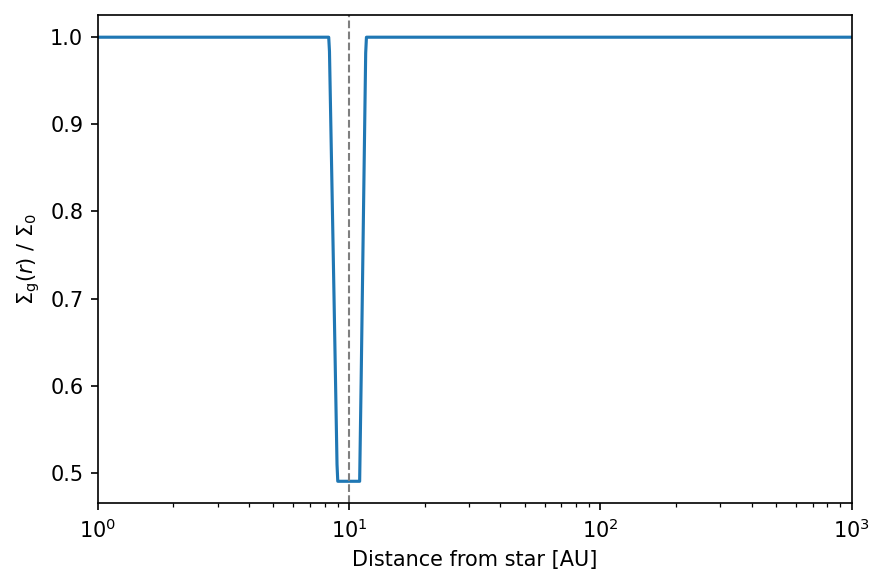

In [5]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(r/c.au, Kanagawa2017_gap_profile(r, rp, q, h, alpha0))
ax.axvline(rp/c.au, ls="--", c="C7", lw=1)
ax.set_xlim(1., 1000.)
ax.set_xlabel("Distance from star [AU]")
ax.set_ylabel(r"$\Sigma_\mathrm{g} \left( r \right)\ /\ \Sigma_0$")
fig.tight_layout()
plt.show()

The inverse of this pertubation needs to be imposed on the turbulent $\alpha$ parameter to produce the desired gap profile in the gas.

## Adding planets

For this example we want to add two planets: Jupiter and Saturn. We therefore add new groups and subgroups to organize them.

In addition to that we want to refine the grid close to the planet locations. For this we use the function similar to the one discussed in an earlier chapter.

In [6]:
def refinegrid(ri, r0, num=3):
    ind = np.argmin(r0 > ri) - 1
    indl = ind-num
    indr = ind+num+1
    ril = ri[:indl]
    rir = ri[indr:]
    N = (2*num+1)*2
    rim = np.empty(N)
    for i in range(0, N, 2):
        j = ind-num+int(i/2)
        rim[i] = ri[j]
        rim[i+1] = 0.5*(ri[j]+ri[j+1])
    return np.concatenate((ril, rim, rir))

In [7]:
from dustpy import Simulation

In [8]:
sim = Simulation()

In [9]:
ri = np.logspace(0., 3., 100) * c.au
ri = refinegrid(ri, 5.2*c.au)
ri = refinegrid(ri, 9.6*c.au)
sim.grid.ri = ri

In [10]:
sim.initialize()

In [11]:
sim.addgroup("planets")
sim.planets.addgroup("jupiter")
sim.planets.addgroup("saturn")

In [12]:
sim.planets.jupiter.addfield("a", 5.2*c.au, description="Semi-major axis [cm]")
sim.planets.jupiter.addfield("M", 1.*c.M_jup, description="Mass [g]")

In [13]:
sim.planets.saturn.addfield("a", 9.6*c.au, description="Semi-major axis [cm]")
sim.planets.saturn.addfield("M", 95*c.M_earth, description="Mass [g]")

The planets are now set up.

In [14]:
sim.planets.toc

Group
    - jupiter: Group
        - a: Field (Semi-major axis [cm])
        - M: Field (Mass [g])
    - saturn: Group
        - a: Field (Semi-major axis [cm])
        - M: Field (Mass [g])


## Viscosity pertubation

We now have to write a funtion that returns the $\alpha$ viscosity parameter profile that imposes the desired gap profile onto the gas surface density from those two planets.

The unperturbed $\alpha$ parameter shall be constant in this model.

In [15]:
alpha0 = 1.e-3

In [16]:
from scipy.interpolate import interp1d

def alpha(sim):
    """Function returns the alpha viscosity profile to create planetary gaps in the gas surface density.
    
    Parameters
    ----------
    sim : Frame
        Simulation frame
        
    Returns
    -------
    alpha : array
        alpha viscosity profile"""
    
    # Unperturbed profile
    alpha = np.ones_like(sim.gas.alpha)
    
    for name, p in sim.planets.__dict__.items():
        # Skip hidden fields
        if name[0] == "_": continue
        
        q = p.M / sim.star.M
        
        # Aspect ratio
        h = sim.gas.Hp / sim.grid.r
        # Interpolate aspect ratio
        f_h = interp1d(sim.grid.r, h)
        hp = f_h(p.a)
        
        # Inverse alpha profile
        alpha /= Kanagawa2017_gap_profile(sim.grid.r, p.a, q, hp, alpha0)
        
    return alpha0 * alpha

This function now produces the $\alpha$ viscosity profile that creates planetary gaps in the gas surface density.

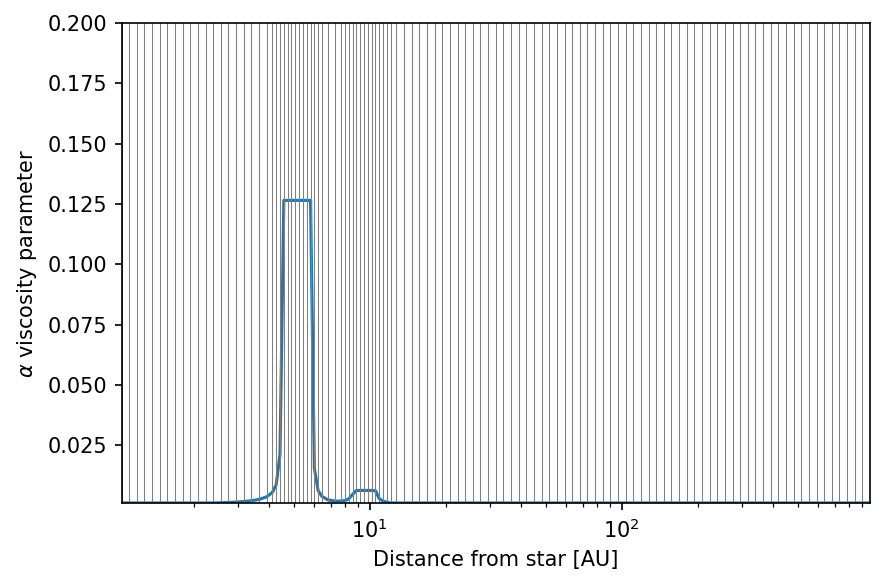

In [17]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(sim.grid.r/c.au, alpha(sim))
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(8.e-4, 2.e-1)
ax.vlines(sim.grid.r/c.au, 1.e-4, 1.e0, lw=0.5, color="C7")
ax.set_xlabel("Distance from star [AU]")
ax.set_ylabel(r"$\alpha$ viscosity parameter")
fig.tight_layout()
plt.show()

We can now assign this profile to the $\alpha$ viscosity parameter.

In [18]:
sim.gas.alpha = alpha(sim)

## Growing planets

Right now we could already start the simulation. But in this demonstration we want to let the planets grow linearly to their final mass. we therefore write a function that returns the planetary mass as a function of time.

In [19]:
def Mplan(t, tini, tfin, Mini, Mfin):
    """Function returns the planetary mass.
    
    Parameters
    ----------
    t : float
        Current time
    tini : float
        Time of start of growth phase
    tfin : float
        Time of end of growth phase
    Mini : float
        Initial planetary mass
    Mfin : float
        Final planetary mass"""
    if t<=tini:
        return Mini
    elif t>=tfin:
        return Mfin
    else:
        return (Mfin-Mini)/(tfin-tini)*(t-tini) + Mini

We want to start with planet masses of $1$ Earth mass and they should reach their final masses after $100\,000$ years. We have to write functions for each planet that returns their mass as a function of time.

In [20]:
def Mjup(sim):
    return Mplan(sim.t, 0., 1.e5*c.year, 1.*c.M_earth, 1.*c.M_jup)

def Msat(sim):
    return Mplan(sim.t, 0., 1.e5*c.year, 1.*c.M_earth, 95.*c.M_earth)

These functions have to be assigned to the updaters of their respective fields.

In [21]:
sim.planets.jupiter.M.updater.updater = Mjup
sim.planets.saturn.M.updater.updater = Msat

We also have to oragnize the update structure of the planets.

In [22]:
sim.planets.jupiter.updater = ["M"]
sim.planets.saturn.updater = ["M"]
sim.planets.updater = ["jupiter", "saturn"]

And we have to tell the main simulation frame to update the planets group. This has to be done before the gas quantities, since `Simulation.gas.alpha` needs to know the planetary masses. So we simply update it in the beginning.

In [23]:
sim.updater = ["planets", "star", "grid", "gas", "dust"]

Since the $\alpha$ viscosity profile is not constant now, we have assign our $\alpha$ function to its updater.

In [24]:
sim.gas.alpha.updater.updater = alpha

To bring the simulation frame into consistency we have to update it.

In [25]:
sim.update()

The planetary masses are now set to their initial values.

In [26]:
msg = "Masses\nJupiter: {:4.2f} M_earth\nSaturn:  {:4.2f} M_earth".format(sim.planets.jupiter.M/c.M_earth, sim.planets.saturn.M/c.M_earth)
print(msg)

Masses
Jupiter: 1.00 M_earth
Saturn:  1.00 M_earth


We can now start the simulation.

In [27]:
sim.writer.datadir = "example_planetary_gaps"

In [28]:
sim.run()


DustPy v1.0.0

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please read README.md on the GitHub repository for
information about the Terms of Usage.

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'example_planetary_gaps'.
Writing file example_planetary_gaps/data0000.hdf5
Writing dump file example_planetary_gaps/frame.dmp
Writing file example_planetary_gaps/data0001.hdf5
Writing dump file example_planet

This is the result of our simulation.

In [29]:
from dustpy import plot

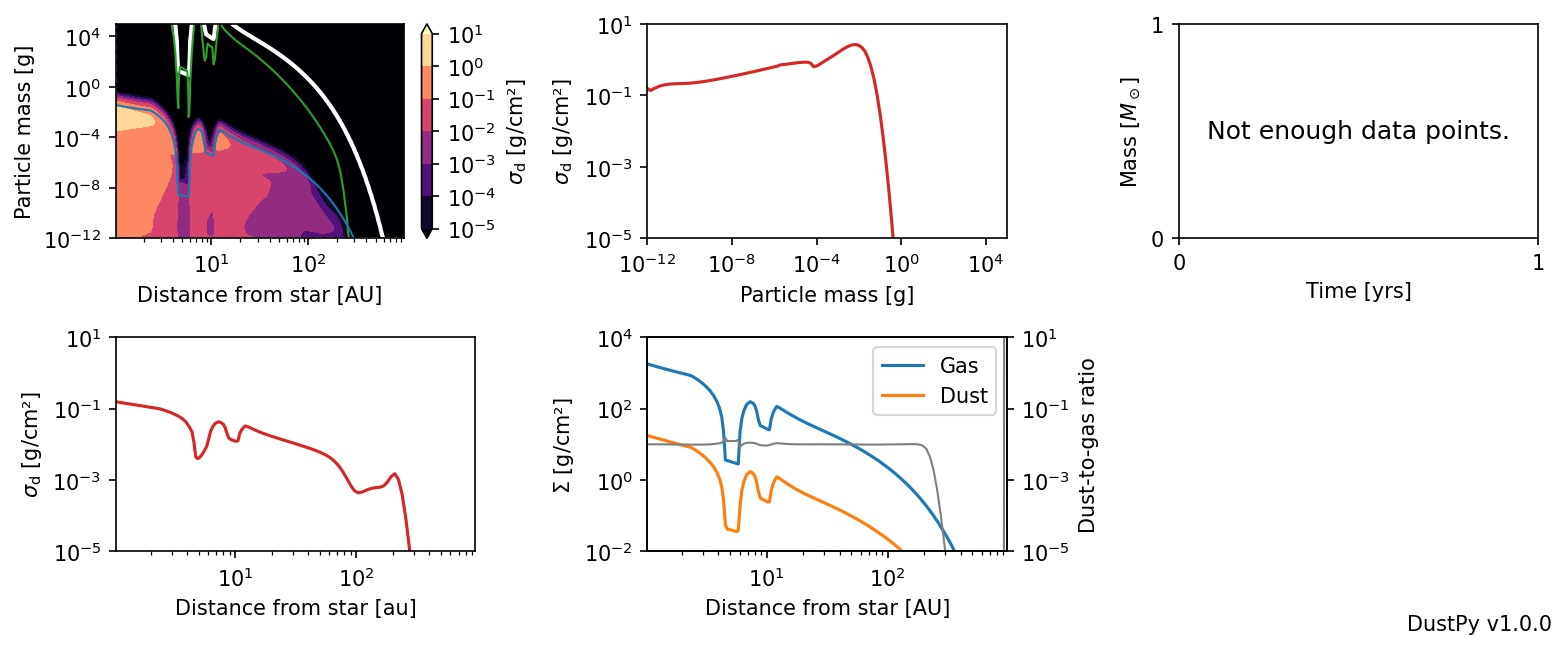

In [30]:
plot.panel(sim)

As can be seen, the core of Jupiter and Saturn carved gaps in the gas disk, which in turn affected the dust evolution.

To see that the planetary masses actually changed we can plot them over time.

In [31]:
t = sim.writer.read.sequence("t")
Mjup = sim.writer.read.sequence("planets.jupiter.M")
Msat = sim.writer.read.sequence("planets.saturn.M")

/tmp/ipykernel_36461/1278233953.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


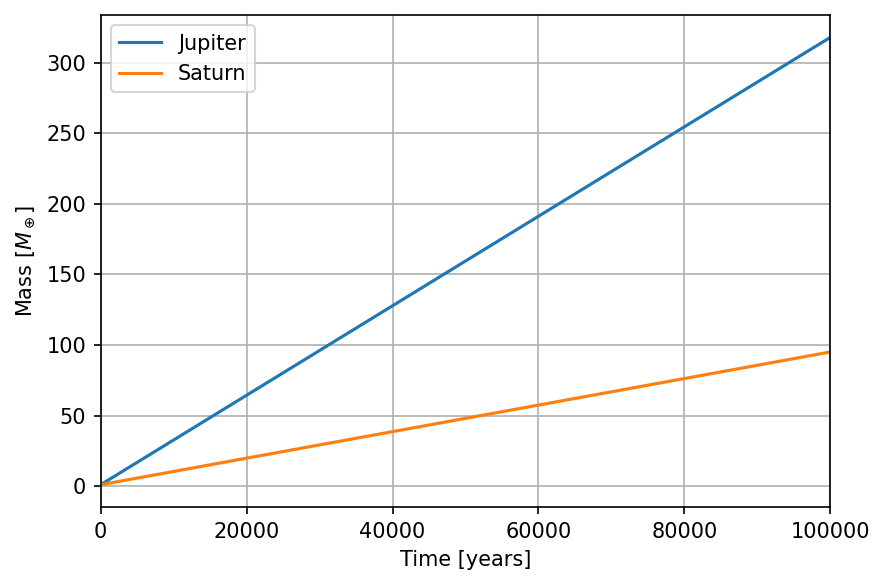

In [32]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(t/c.year, Mjup/c.M_earth, label="Jupiter")
ax.plot(t/c.year, Msat/c.M_earth, label="Saturn")
ax.legend()
ax.set_xlim(t[0]/c.year, t[-1]/c.year)
ax.grid(b=True)
ax.set_xlabel("Time [years]")
ax.set_ylabel("Mass [$M_\oplus$]")
fig.tight_layout()
plt.show()